## Task

The task is to create a language model that can effectively classify diseases based on a short description of its symptoms.


The dataset contains 50 descriptions for each disease, which turns out too less to train a model from scratch. Hence, I tried using a pretrained
transformer model for this. Thanks to 🤗.


## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

plt.style.use('ggplot')
np.__version__

'1.22.4'

In [2]:
!pip install transformers

## Loading the data

In [3]:
df = pd.read_csv('/content/agumented-data (1).csv')
df.head()

,Unnamed: 0,label,text
0,NaN,Psoriasis,""" lily got red and inflammatory skin around he..."
1,NaN,Psoriasis,""" nurses have experienced difficulty sleeping ..."
2,NaN,Psoriasis,""" my arm, face and nails burn all red and irri..."
3,NaN,Psoriasis,""" my armor has a dull colour, particularly of ..."
4,NaN,Psoriasis,""" i've had difficulties sleeping because given..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648 entries, 0 to 27647
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3600 non-null   float64
 1   label       27648 non-null  object 
 2   text        27648 non-null  object 
dtypes: float64(1), object(2)
memory usage: 648.1+ KB


Creating encodings for disease.

In [5]:
int2label = {}

for i, disease in enumerate(df['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

int2label, label2int

({0: 'Psoriasis',
  1: 'Varicose Veins',
  2: 'Typhoid',
  3: 'Chicken pox',
  4: 'Impetigo',
  5: 'Dengue',
  6: 'Fungal infection',
  7: 'Common Cold',
  8: 'Pneumonia',
  9: 'Dimorphic Hemorrhoids',
  10: 'Arthritis',
  11: 'Acne',
  12: 'Bronchial Asthma',
  13: 'Hypertension',
  14: 'Migraine',
  15: 'Cervical spondylosis',
  16: 'Jaundice',
  17: 'Malaria',
  18: 'urinary tract infection',
  19: 'allergy',
  20: 'gastroesophageal reflux disease',
  21: 'drug reaction',
  22: 'peptic ulcer disease',
  23: 'diabetes'},
 {'Psoriasis': 0,
  'Varicose Veins': 1,
  'Typhoid': 2,
  'Chicken pox': 3,
  'Impetigo': 4,
  'Dengue': 5,
  'Fungal infection': 6,
  'Common Cold': 7,
  'Pneumonia': 8,
  'Dimorphic Hemorrhoids': 9,
  'Arthritis': 10,
  'Acne': 11,
  'Bronchial Asthma': 12,
  'Hypertension': 13,
  'Migraine': 14,
  'Cervical spondylosis': 15,
  'Jaundice': 16,
  'Malaria': 17,
  'urinary tract infection': 18,
  'allergy': 19,
  'gastroesophageal reflux disease': 20,
  'drug reacti

## Data Distribution

The dataset contains 24 diseases and each disease has 50 descriptions of the respective symptoms.

Text(0.5, 1.0, 'Count of each disease')

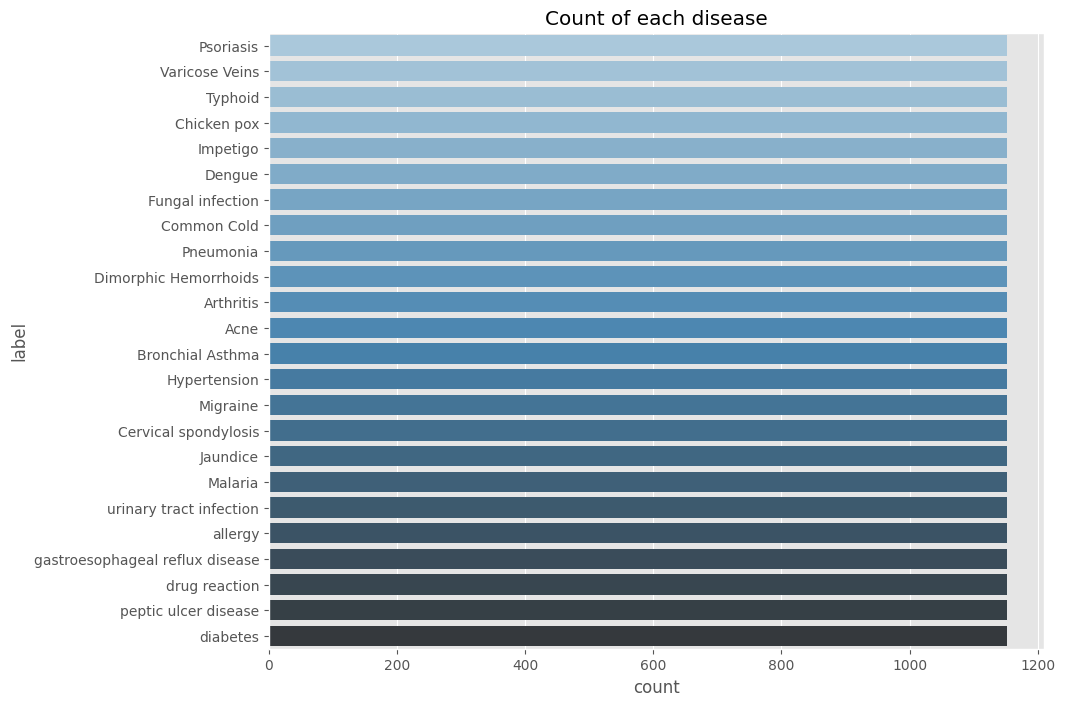

In [6]:
plt.figure(figsize = (10, 8))

sea.countplot(y = df['label'], palette = 'Blues_d')
plt.title('Count of each disease')

## Distribution of the lenght of description

  0%|          | 0/1200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Distribution of description length')

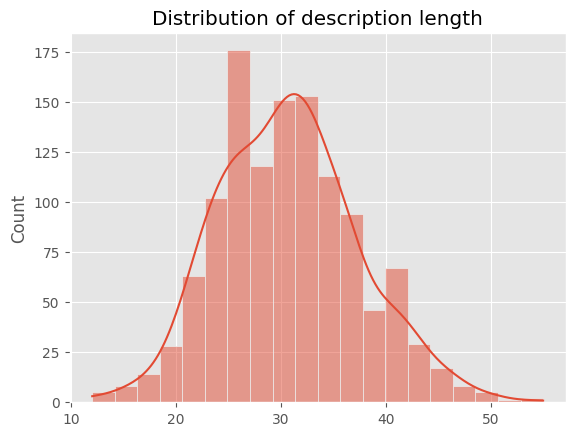

In [8]:
length = []
for txt in tqdm(df['text'].values):
    length.append(len(txt.split()))

sea.histplot(length, kde = True, bins = 20)
plt.title('Distribution of description length')

In [9]:
df['label'] = df['label'].map(lambda x : label2int[x])

In [10]:
X, y = df['text'].values, df['label'].values

x_tokenizer = Tokenizer(filters = '')
x_tokenizer.fit_on_texts(X)
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 2414


## Creating the train and testing data

90% of the dataset is used for training and remaining 10% for validation and testing.

In [11]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape


((1080,), (120,), (1080,), (120,))

## Converting the data into `tf.data.Dataset`

1. The tokenizer of pretrained bert is downloaded and used.
2. `train_dataset` and `val_dataset` is created using `tf.data.Dataset` with batch size 8.

In [12]:
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)


## Loading the Pretrained BERT Model

1. We pass the label encodings to the model.
2. We use SparseCategoricalCrossentropy for the loss function.
3. Adam for the optimizer with a small learning rate of 0.00003


In [13]:
num_classes = 24

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = num_classes,
    id2label = int2label,
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])

model

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
for layer in model.layers:
    print(layer, layer.trainable)

<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7928f2c8e380> True
<keras.layers.regularization.dropout.Dropout object at 0x7928f2a26ec0> True
<keras.layers.core.dense.Dense object at 0x7928f2a272b0> True


## Fine tuning the model

1. The model is fined tuned for 3 epochs.

In [ ]:
EPOCHS = 3

history = model.fit(train_dataset,
          epochs = EPOCHS,
          validation_data = val_dataset)

Epoch 1/3
 22/135 [===>..........................] - ETA: 1:49:53 - loss: 3.2383 - accuracy: 0.0455

## Plotting the loss and accuracy plot.

In [ ]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()


## Testing the model on custom input.

In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = num_classes)
pred1 = pipe("I am experiencing rashes on my skin. It is itchy and is now swelling. Even my sking is starting to peel. ")
pred2 = pipe("I have constipation and belly pain, and it's been really uncomfortable. The belly pain has been getting worse and is starting to affect my daily life. Moreover, I get chills every night, followed by a mild fever.")


print(pred1[0][:2])
print(pred2[0][:2])